## Alinging Raster DEM to sparse altimetry points [Preliminary/in-progress, please be patient]
#### Adapted from the [ASP Documentation](https://stereopipeline.readthedocs.io/en/latest/tools/pc_align.html#pc-align)

In [44]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
import requests
import numpy as np
import pandas as pd
import os,sys,glob
import matplotlib.pyplot as plt
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable
from distutils.spawn import find_executable
import geopandas as gpd
import dask
import zipfile
from pyproj import Proj, transform
import subprocess
from fetch_dem import opentopo_utils
import asp_binder_utils as asp_utils
import xyzservices
import rioxarray
import rasterio
from shapely.geometry import box
from sliderule import sliderule, icesat2
import contextily as ctx

import xyzservices

## Universal settings

In [46]:
terrain_map = xyzservices.providers.Esri.WorldImagery() #Used to render basemap
#verbose = False #  Will only print the bash commands and whether the process ran sucessfully or not
verbose = True # will print all the logs printed by ASP
alignment_algortihm = 'point-to-point' # suggested to use point-to-point if the terrain variability is low (more flat terrain cases)
max_displacement = 30 #you might have to play with this to adapt to different datasets
tsrs = 'EPSG:32610' # input projection
tr = 30 #DEM resolution

## Preprocessing 0: Data Download
* For the purpose of this tutorial, we will register the ASTER DEM produced using the stereo processing tutorial to sparse elevation values derived by the [ICESat-2 altimetry mission](https://icesat-2.gsfc.nasa.gov/).
    * To run this tutorial without running the stereo processing tutorial, we have archived the ASTER DEM produced using the ASTER camera models and orthorectified imagery (Type 3) on [Zenodo](https://zenodo.org/records/10208419). We will fetch it directly from zenodo.
    * We will download ICESat-2 using the [Sliderule Earth](https://slideruleearth.io/web/) package.



* Alternatively, users can bring their own source DEM, and explore the tutorial using the same! Please follow the below guidelines to do so.
    * To perform this in a github codespace session, go to the file explorer on the right, do a right click and select upload, then upload the DEMs of your choice from the file browser.
    * See also this [stack exhange answer](https://stackoverflow.com/questions/62284623/how-can-i-upload-a-file-to-a-github-codespaces-environment)

* When you change the DEMs to a different site than the site used by default, make sure to change the projected corrdinate system definition (t_srs) 

### 0.1 Download ASTER ASP DEM over Mt. Rainier

In [47]:
aster_dem_fn = 'aster_orthorectified-DEM.tif'
#ASTER Sample has been staged on Zenodo:
#https://zenodo.org/record/7972223/files/AST_L1A_00307312017190728_20200218153629_19952.zip?download=1
zenodo_url = 'https://zenodo.org/records/10208419/files/aster_orthorectified-DEM.tif?download=1'
if os.path.exists(aster_dem_fn):
    print(f"file {aster_dem_fn} already downloaded")
else:
    response = requests.get(zenodo_url)
    #Check for 200
    if response.ok:
        print ('OK!')
    else:
        print ('Query failed')
        sys.exit()
    #Write to disk
    open(aster_dem_fn, 'wb').write(response.content)
    print(f"file {aster_dem_fn} saved")

file aster_orthorectified-DEM.tif already downloaded


### 0.2 Query ICESat-2 points over DEM extent and limit to during snow-free conditions

In [48]:

# get aoi extent in geographic coordinates
geo_crs = 'EPSG:4326'
aoi_extent = asp_utils.subsetBBox(aster_dem_fn,geo_crs)
aoi_box = gpd.GeoDataFrame({'idx':[0],'geometry':box(*aoi_extent)},crs=geo_crs)
#in_crs = rasterio.open(dem_file).crs

/srv/conda/envs/notebook/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/srv/conda/envs/notebook/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/workspaces/asp_tutorials/tutorials/asp_binder_utils.py:114: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
 

In [49]:
region = sliderule.toregion(aoi_box)
# Build ATL06 Request Parameters
parms = {
    "poly": region["poly"],
    "srt": icesat2.SRT_LAND,
    "cnf": icesat2.CNF_SURFACE_HIGH,
    "ats": 7.0,
    "cnt": 10,
    "len": 40.0,
    "res": 20.0,
    
}

# Make ATL06 Request
atl06 = icesat2.atl06p(parms) #dataframe with ICESat-2 points over the study area

In [50]:
## Plot ICESat-2 points over the aoi
atl06.reset_index()[['geometry','h_mean']].sample(n=10000).explore(column='h_mean',style_kwds=dict(fill=False),tiles=terrain_map)

KeyboardInterrupt: 

In [ ]:
atl06.crs

<Geographic 3D CRS: EPSG:7912>
Name: ITRF2014
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
- h[up]: Ellipsoidal height (metre)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: International Terrestrial Reference Frame 2014
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [ ]:
wgs84_projection = 'EPSG:4326'+'EPSG:4979'
atl06_epsg_4326 = atl06.to_crs(epsg="4326+4979")

In [ ]:
atl06_epsg_4326.crs

<Geographic 3D CRS: EPSG:4979>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
- h[up]: Ellipsoidal height (metre)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### 0.3 Save ICESat-2 points to disk for alignment purposes 

In [ ]:
atl06_epsg_4326['lon'] = atl06_epsg_4326.geometry.x
atl06_epsg_4326['lat'] = atl06_epsg_4326.geometry.y
altimetry_csv_fn_all = 'ICESat-2_all_control_points.csv'
atl06_epsg_4326[['lon','lat','h_mean']].to_csv(altimetry_csv_fn_all,index=False)

## 1. Perform Co-registration (using ASP's [pc_align](https://stereopipeline.readthedocs.io/en/latest/tools/pc_align.html) algorithm)

In [ ]:

pc_align = find_executable('pc_align')
ref_alitmetry = altimetry_csv_fn_all
src_dem = aster_dem_fn
alignment_dir  = 'alignment_sparse_altimetry_all/aster_aligned2ICESat2'
#csv_proj4 = '+proj=longlat +ellps=GRS80 +no_defs +type=crs' #EPSG:7912 (https://epsg.io/7912#google_vignette)
csv_proj4 = '+proj=longlat +datum=WGS84 +no_defs +type=crs' #EPSG:4326 https://epsg.io/4326#google_vignette
altimetry_datum = 'WGS84'
csv_format = '1:lon,2:lat,3:height_above_datum'
alignment_call = f"{pc_align}  --compute-translation-only --highest-accuracy  --csv-format '{csv_format}' --csv-proj4 '{csv_proj4}' --save-inv-transformed-reference-points --alignment-method {alignment_algortihm}  --max-displacement {50} {src_dem} {ref_alitmetry} -o {alignment_dir}"
asp_utils.run_bash_command(alignment_call,verbose=verbose)

/srv/StereoPipeline/bin/pc_align  --compute-translation-only --highest-accuracy  --csv-format '1:lon,2:lat,3:height_above_datum' --csv-proj4 '+proj=longlat +datum=WGS84 +no_defs +type=crs' --save-inv-transformed-reference-points --alignment-method point-to-point  --max-displacement 50 aster_orthorectified-DEM.tif ICESat-2_all_control_points.csv -o alignment_sparse_altimetry_all/aster_aligned2ICESat2


	--> Setting number of processing threads to: 4
Writing log info to: alignment_sparse_altimetry_all/aster_aligned2ICESat2-log-pc_align-02-28-2146-3763.txt
Detected datum from aster_orthorectified-DEM.tif:
Geodetic Datum --> Name: WGS_1984  Spheroid: WGS 84  Semi-major axis: 6378137  Semi-minor axis: 6356752.3142451793  Meridian: Greenwich at 0  Proj4 Str: +datum=WGS84
Will use datum (for CSV files): Geodetic Datum --> Name: WGS_1984  Spheroid: WGS 84  Semi-major axis: 6378137  Semi-minor axis: 6356752.3142451793  Meridian: Greenwich at 0  Proj4 Str: +datum=WGS84
Computing the intersection of the bounding boxes of the reference and source points using 9000000 sample points.
Reference box: (Origin: (-122.343, 46.7156) width: 0.982009 height: 0.622141)
Source box:    (Origin: (-122.344, 46.7216) width: 0.990485 height: 0.608127)
Intersection reference box:  (Origin: (-122.343, 46.7216) width: 0.982009 height: 0.608127)
Intersection source    box:  (Origin: (-122.343, 46.7216) width: 0.982

writing to alignment_sparse_altimetry_all/aster_aligned2ICESat2-iterationInfo.csv


Match ratio: 0.75001
Alignment took 7.72005 [s]
Number of errors: 100000
Output: error percentile of smallest errors (meters): 16%: 2.45201, 50%: 8.84691, 84%: 21.3643
Output: mean of smallest errors (meters): 25%: 1.91543, 50%: 4.07123, 75%: 6.85618, 100%: 11.5429
Final error computation took 0.166117 [s]
Alignment transform (origin is planet center):
                 1                  0                  0 -5.298334248829633
                 0                  1                  0  5.792856276966631
                 0                  0                  1  -4.79206688515842
                 0                  0                  0                  1
Centroid of source points (Cartesian, meters): Vector3(-2302430.7,-3697680.8,4644459.5)
Centroid of source points (lat,lon,z): Vector3(47.028163,-121.90924,765.31372)

Translation vector (Cartesian, meters): Vector3(-5.2983342,5.7928563,-4.7920669)
Translation vector (North-East-Down, meters): Vector3(-1.7175396,-7.5596444,4.9492695)
Trans

Child returned 0


### 1.1 Grid the output DEM

In [ ]:
point2dem = find_executable('point2dem')
tsrs = tsrs
#p2dem_args = '--errorimage'
nodata_value = -9999.0
pointcloud = glob.glob(alignment_dir+'*-trans_reference.tif')[0]
print ("Gridding pointcloud {} at {} m/px".format(pointcloud,tr))
point2dem_call  = f"{point2dem} --tr {tr} --t_srs '{tsrs}' --nodata-value {nodata_value} {pointcloud}"
asp_utils.run_bash_command(point2dem_call,verbose=verbose)
aligned_dem = glob.glob(alignment_dir+'*-DEM.tif')[0]
print("DEM saved at {}".format(aligned_dem))

Gridding pointcloud alignment_sparse_altimetry_all/aster_aligned2ICESat2-trans_reference.tif at 30 m/px
/srv/StereoPipeline/bin/point2dem --tr 30 --t_srs 'EPSG:32610' --nodata-value -9999.0 alignment_sparse_altimetry_all/aster_aligned2ICESat2-trans_reference.tif
	--> Setting number of processing threads to: 4
Writing log info to: alignment_sparse_altimetry_all/aster_aligned2ICESat2-trans_reference-log-point2dem-02-28-2207-10974.txt
The point cloud files must have an equal number of channels which must be 4 or 6 to be able to remove outliers.
Statistics: [********************************************************] Complete!
QuadTree: [**********************************************************] Complete!
	-- Starting DEM rasterization --
	--> DEM spacing: 30 pt/px
	             or: 0.0333333 px/pt
Creating output file that is Vector2(2461,2284) px.
Writing: alignment_sparse_altimetry_all/aster_aligned2ICESat2-trans_reference-DEM.tif
DEM: [***********........................................

DEM: [***************************************************************] Complete!
Percentage of valid pixels: 73.7867%
DEM saved at alignment_sparse_altimetry_all/aster_aligned2ICESat2-trans_reference-DEM.tif


Child returned 0


## 2. Compute difference of between pointclouds

### 2.1 Initial DEM and altimetry difference

In [ ]:
geodiff = find_executable('geodiff')
initial_output_prefix = 'initial'
print(f"Computing elevation difference before alignment between {ref_alitmetry} and {src_dem}\n\n")
geodiff_call = f"{geodiff} {ref_alitmetry} {src_dem} --csv-format {csv_format} --csv-proj4 '{csv_proj4}' -o {initial_output_prefix}"
asp_utils.run_bash_command(geodiff_call,verbose=verbose)
initial_elevation_difference_fn = glob.glob(initial_output_prefix+'-diff.csv')[0]
print("\n\nInitial elevation difference saved at {}".format(initial_elevation_difference_fn))

Computing elevation difference before alignment between ICESat-2_all_control_points.csv and aster_orthorectified-DEM.tif


/srv/StereoPipeline/bin/geodiff ICESat-2_all_control_points.csv aster_orthorectified-DEM.tif --csv-format 1:lon,2:lat,3:height_above_datum --csv-proj4 '+proj=longlat +datum=WGS84 +no_defs +type=crs' -o initial
	--> Setting number of processing threads to: 4
	Found input nodata value for DEM: -3.40282e+38
Max difference:       1236.26 meters
Min difference:       -524.916 meters
Mean difference:      16.0876 meters
StdDev of difference: 68.6609 meters
Median difference:    4.17504 meters
Writing difference file: initial-diff.csv


Initial elevation difference saved at initial-diff.csv


Child returned 0


### 2.2 Final DEM and altimetry difference

In [ ]:
geodiff = find_executable('geodiff')
final_output_prefix = 'final'
print(f"Computing elevation difference before alignment between {ref_alitmetry} and {aligned_dem}\n\n")
geodiff_call = f"{geodiff} {ref_alitmetry} {aligned_dem} --csv-format {csv_format} --csv-proj4 '{csv_proj4}' -o {final_output_prefix}"
asp_utils.run_bash_command(geodiff_call,verbose=verbose)
final_elevation_difference_fn = glob.glob(final_output_prefix+'-diff.csv')[0]
print("\n\nFinal elevation difference saved at {}".format(initial_elevation_difference_fn))

Computing elevation difference before alignment between ICESat-2_all_control_points.csv and alignment_sparse_altimetry_all/aster_aligned2ICESat2-trans_reference-DEM.tif


/srv/StereoPipeline/bin/geodiff ICESat-2_all_control_points.csv alignment_sparse_altimetry_all/aster_aligned2ICESat2-trans_reference-DEM.tif --csv-format 1:lon,2:lat,3:height_above_datum --csv-proj4 '+proj=longlat +datum=WGS84 +no_defs +type=crs' -o final
	--> Setting number of processing threads to: 4
	Found input nodata value for DEM: -9999
Max difference:       1233.57 meters
Min difference:       -531.11 meters
Mean difference:      11.2705 meters
StdDev of difference: 68.7459 meters
Median difference:    -0.660842 meters
Writing difference file: final-diff.csv


Final elevation difference saved at initial-diff.csv


Child returned 0


In [ ]:
def read_geodiff(csv_fn):
    #from David Shean
    resid_cols=['lon', 'lat', 'diff']
    resid_df = pd.read_csv(csv_fn, comment='#', names=resid_cols)
    resid_gdf = gpd.GeoDataFrame(resid_df, geometry=gpd.points_from_xy(resid_df['lon'], resid_df['lat'], crs='EPSG:4326'))
    return resid_gdf

## Plot results

In [ ]:
initial_diff_gdf = read_geodiff(initial_elevation_difference_fn)
final_diff_gdf = read_geodiff(final_elevation_difference_fn)



In [ ]:
initial_diff_gdf.describe()

lon            lat           diff
count  459929.000000  459929.000000  459929.000000
mean     -121.903676      47.024284      16.087601
std         0.230075       0.154826      68.661002
min      -122.337803      46.722582    -524.915808
25%      -122.097212      46.891081      -4.151846
50%      -121.928281      47.017211       4.175042
75%      -121.696874      47.156537      15.071355
max      -121.362113      47.328882    1236.264812

In [ ]:
final_diff_gdf.describe()

lon            lat           diff
count  460571.000000  460571.000000  460571.000000
mean     -121.903454      47.024363      11.270501
std         0.230233       0.154880      68.745974
min      -122.337803      46.722582    -531.109705
25%      -122.097182      46.891116      -8.993052
50%      -121.927619      47.017265      -0.660842
75%      -121.696074      47.156676      10.218073
max      -121.362064      47.328882    1233.574087

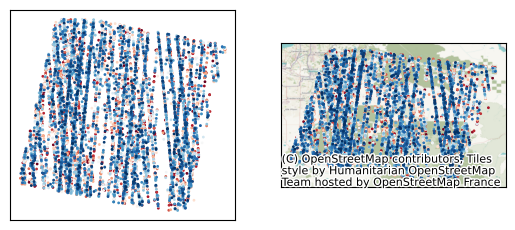

In [60]:
f,ax = plt.subplots(1,2,sharex=True,sharey=True)
markersize = 1 
initial_diff_gdf.sample(n=10000).plot(ax=ax[0],cmap='RdBu',vmin=-10,vmax=10,markersize=markersize)
final_diff_gdf.sample(n=10000).plot(ax=ax[1],cmap='RdBu',vmin=-10,vmax=10,markersize=markersize)
for axa in ax.ravel():
    axa.set_xticks([])
    axa.set_yticks([])
ctx.add_basemap(ax=axa,crs='EPSG:4326')

In [64]:
initial_diff_gdf['diff']

0           3.440482
1           8.877410
2          13.485358
3          17.309789
4          16.580789
             ...    
459924    384.686892
459925    374.451331
459926    379.893068
459927    401.059748
459928    394.067312
Name: diff, Length: 459929, dtype: float64

(-50.0, 50.0)

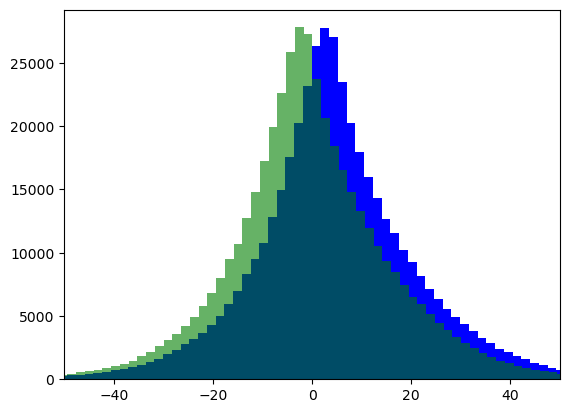

In [67]:
f,ax = plt.subplots()
ax.hist(initial_diff_gdf['diff'].values,color='blue',bins=1000)
ax.hist(final_diff_gdf['diff'].values,color='green',alpha=0.6,bins=1000)
ax.set_xlim((-50,50))

### OLD Stuff

In [68]:
# Limit points to snow-free month (in case of Mt. Rainier, September)
snow_free_month = 9
mask = atl06.index.month == snow_free_month
atl06_snow_free = atl06[mask]

In [69]:
atl06_snow_free.shape
print(f"From total {len(atl06)} ICESat-2 points, {len(atl06_snow_free)} points were acquired in September")

From total 640605 ICESat-2 points, 54881 points were acquired in September


In [32]:
atl06_snow_free.reset_index()[['geometry','h_mean']].sample(n=10000).explore(column='h_mean',style_kwds=dict(fill=False),tiles=terrain_map)

In [71]:
atl06_snow_free = atl06_snow_free.to_crs(epsg="4326+4979")
atl06_snow_free['lon'] = atl06_snow_free.geometry.x
atl06_snow_free['lat'] = atl06_snow_free.geometry.y
altimetry_csv_sept_fn = 'ICESat-2_september_control_points.csv'
atl06_snow_free[['lon','lat','h_mean']].to_csv(altimetry_csv_sept_fn,index=False)

In [72]:

pc_align = find_executable('pc_align')
ref_alitmetry = altimetry_csv_sept_fn
src_dem = aster_dem_fn
alignment_dir  = 'alignment_sparse_altimetry_sept/aster_aligned2ICESat2'
#csv_proj4 = '+proj=longlat +ellps=GRS80 +no_defs +type=crs' #EPSG:7912 (https://epsg.io/7912#google_vignette)
csv_proj4 = '+proj=longlat +datum=WGS84 +no_defs +type=crs' #EPSG:4326 https://epsg.io/4326#google_vignette
altimetry_datum = 'WGS84'
csv_format = '1:lon,2:lat,3:height_above_datum'
alignment_call = f"{pc_align}  --compute-translation-only --highest-accuracy  --csv-format '{csv_format}' --csv-proj4 '{csv_proj4}' --save-inv-transformed-reference-points --alignment-method {alignment_algortihm}  --max-displacement {50} {src_dem} {ref_alitmetry} -o {alignment_dir}"
asp_utils.run_bash_command(alignment_call,verbose=verbose)

/srv/StereoPipeline/bin/pc_align  --compute-translation-only --highest-accuracy  --csv-format '1:lon,2:lat,3:height_above_datum' --csv-proj4 '+proj=longlat +datum=WGS84 +no_defs +type=crs' --save-inv-transformed-reference-points --alignment-method point-to-point  --max-displacement 50 aster_orthorectified-DEM.tif ICESat-2_september_control_points.csv -o alignment_sparse_altimetry_sept/aster_aligned2ICESat2
	--> Setting number of processing threads to: 4

Creating output directory: "alignment_sparse_altimetry_sept".
Writing log info to: alignment_sparse_altimetry_sept/aster_aligned2ICESat2-log-pc_align-02-28-2237-22503.txt
Detected datum from aster_orthorectified-DEM.tif:
Geodetic Datum --> Name: WGS_1984  Spheroid: WGS 84  Semi-major axis: 6378137  Semi-minor axis: 6356752.3142451793  Meridian: Greenwich at 0  Proj4 Str: +datum=WGS84
Will use datum (for CSV files): Geodetic Datum --> Name: WGS_1984  Spheroid: WGS 84  Semi-major axis: 6378137  Semi-minor axis: 6356752.3142451793  Meridi

writing to alignment_sparse_altimetry_sept/aster_aligned2ICESat2-iterationInfo.csv


Match ratio: 0.750006
Alignment took 2.92577 [s]
Number of errors: 41097
Output: error percentile of smallest errors (meters): 16%: 3.05976, 50%: 10.0026, 84%: 20.644
Output: mean of smallest errors (meters): 25%: 2.38572, 50%: 4.86838, 75%: 7.65556, 100%: 11.8941
Final error computation took 0.07563 [s]
Alignment transform (origin is planet center):
                 1                  0                  0 0.5455883839167655
                 0                  1                  0  32.72911132918671
                 0                  0                  1  8.341710251756012
                 0                  0                  0                  1
Centroid of source points (Cartesian, meters): Vector3(-2293577.8,-3705133.4,4643319.4)
Centroid of source points (lat,lon,z): Vector3(47.010237,-121.75863,1064.3416)

Translation vector (Cartesian, meters): Vector3(0.54558838,32.729111,8.3417103)
Translation vector (North-East-Down, meters): Vector3(26.253996,-16.762806,13.069529)
Translati

Child returned 0


In [74]:
point2dem = find_executable('point2dem')
tsrs = tsrs
#p2dem_args = '--errorimage'
nodata_value = -9999.0
pointcloud = glob.glob(alignment_dir+'*-trans_reference.tif')[0]
print ("Gridding pointcloud {} at {} m/px".format(pointcloud,tr))
point2dem_call  = f"{point2dem} --tr {tr} --t_srs '{tsrs}' --nodata-value {nodata_value} {pointcloud}"
asp_utils.run_bash_command(point2dem_call,verbose=verbose)
aligned_dem = glob.glob(alignment_dir+'*-DEM.tif')[0]
print("DEM saved at {}".format(aligned_dem))

Gridding pointcloud alignment_sparse_altimetry_sept/aster_aligned2ICESat2-trans_reference.tif at 30 m/px
/srv/StereoPipeline/bin/point2dem --tr 30 --t_srs 'EPSG:32610' --nodata-value -9999.0 alignment_sparse_altimetry_sept/aster_aligned2ICESat2-trans_reference.tif
	--> Setting number of processing threads to: 4
Writing log info to: alignment_sparse_altimetry_sept/aster_aligned2ICESat2-trans_reference-log-point2dem-02-28-2243-24681.txt
The point cloud files must have an equal number of channels which must be 4 or 6 to be able to remove outliers.
Statistics: [********************************************************] Complete!
QuadTree: [**********************************************************] Complete!
	-- Starting DEM rasterization --
	--> DEM spacing: 30 pt/px
	             or: 0.0333333 px/pt
Creating output file that is Vector2(2461,2284) px.
Writing: alignment_sparse_altimetry_sept/aster_aligned2ICESat2-trans_reference-DEM.tif
DEM: [***********************************************

Child returned 0


In [75]:
geodiff = find_executable('geodiff')
initial_output_prefix = 'initial'
print(f"Computing elevation difference before alignment between {ref_alitmetry} and {src_dem}\n\n")
geodiff_call = f"{geodiff} {ref_alitmetry} {src_dem} --csv-format {csv_format} --csv-proj4 '{csv_proj4}' -o {initial_output_prefix}"
asp_utils.run_bash_command(geodiff_call,verbose=verbose)
initial_elevation_difference_fn = glob.glob(initial_output_prefix+'-diff.csv')[0]
print("\n\nInitial elevation difference saved at {}".format(initial_elevation_difference_fn))

Computing elevation difference before alignment between ICESat-2_september_control_points.csv and aster_orthorectified-DEM.tif


/srv/StereoPipeline/bin/geodiff ICESat-2_september_control_points.csv aster_orthorectified-DEM.tif --csv-format 1:lon,2:lat,3:height_above_datum --csv-proj4 '+proj=longlat +datum=WGS84 +no_defs +type=crs' -o initial
	--> Setting number of processing threads to: 4
	Found input nodata value for DEM: -3.40282e+38
Max difference:       740.292 meters
Min difference:       -253.196 meters
Mean difference:      24.2098 meters
StdDev of difference: 85.8822 meters
Median difference:    6.68651 meters
Writing difference file: initial-diff.csv


Initial elevation difference saved at initial-diff.csv


Child returned 0


In [76]:
geodiff = find_executable('geodiff')
final_output_prefix = 'final'
print(f"Computing elevation difference before alignment between {ref_alitmetry} and {aligned_dem}\n\n")
geodiff_call = f"{geodiff} {ref_alitmetry} {aligned_dem} --csv-format {csv_format} --csv-proj4 '{csv_proj4}' -o {final_output_prefix}"
asp_utils.run_bash_command(geodiff_call,verbose=verbose)
final_elevation_difference_fn = glob.glob(final_output_prefix+'-diff.csv')[0]
print("\n\nFinal elevation difference saved at {}".format(final_elevation_difference_fn))

Computing elevation difference before alignment between ICESat-2_september_control_points.csv and alignment_sparse_altimetry_sept/aster_aligned2ICESat2-trans_reference-DEM.tif


/srv/StereoPipeline/bin/geodiff ICESat-2_september_control_points.csv alignment_sparse_altimetry_sept/aster_aligned2ICESat2-trans_reference-DEM.tif --csv-format 1:lon,2:lat,3:height_above_datum --csv-proj4 '+proj=longlat +datum=WGS84 +no_defs +type=crs' -o final
	--> Setting number of processing threads to: 4
	Found input nodata value for DEM: -9999
Max difference:       737.057 meters
Min difference:       -273.715 meters
Mean difference:      12.9091 meters
StdDev of difference: 85.508 meters
Median difference:    -4.59955 meters
Writing difference file: final-diff.csv


Final elevation difference saved at final-diff.csv


Child returned 0


## Shashank TODO:
* Figure out altimetry_datum conversion [DONE]
* Run using all points probably [DONE, but might want to change study area]
* Plot results [In-progress]